In [1]:
import pandas as pd #importing the Pandas Library as 'pd'
import numpy as np

#Imports spatial libraries
from keplergl import KeplerGl #importing KeplerGl
import geopandas as gpd #importing geopandas as 'gpd'
from shapely.geometry import Point
from shapely.geometry import box
import shapely.wkt
from geopy.geocoders import Nominatim # Imports the geopy for the geocoding
import geojson
from geojson import Point, Feature, FeatureCollection, dump

import xml.etree.ElementTree as ET
from geojson_rewind import rewind

import requests

import matplotlib.pyplot as plt


from time import time

# Takes the food outlet locations, calculate 10 minute isochrone and convert to geojson

In [2]:
filename = "Data/Out/Affordable_food_iniatives.geojson"

file = open(filename)
Affordable_food_outlets = gpd.read_file(file)

In [3]:
# Characteristics for API calls to calculate 10 minute walking time

urlBase = 'https://api.mapbox.com/isochrone/v1/mapbox/'
profile = 'walking/'
minutes = 10
mapboxglaccessToken = 'pk.eyJ1Ijoiam9obmFyZGF2aWVzIiwiYSI6ImNpeHRmZjhlYjAwMmUycW9qbHRvem0xa3gifQ.oQ9cnn8b5HATalxv9rppYg'


# Function to make calls to the mapbox isochrone apis
def isochrone_api(x):
   api_call=urlBase+profile +str(x['lon'])+','+str(x['lat'])+'?contours_minutes='+str(minutes)+'&polygons=true&access_token='+mapboxglaccessToken
   try:
    walk_dist=requests.get(api_call)
    walk_iso= walk_dist.json()['features'][0]
   except:
    walk_iso="call_failed"
   return walk_iso

In [4]:
# Call the isochrone API for each of the food output locations
Affordable_food_outlets['walking_dist']=Affordable_food_outlets.apply(isochrone_api,axis=1)

In [5]:
# Take the outputs and turn into json
travel_distances = FeatureCollection(Affordable_food_outlets['walking_dist'].values.tolist())

In [6]:
# Ensures geojson follows the right handed rule
travel_distances= rewind(travel_distances)

In [7]:
# Convert to geopandas data frame
travel_distances = gpd.GeoDataFrame.from_features(travel_distances["features"])

In [8]:
# Set projection
travel_distances= travel_distances.set_crs("EPSG:4326")

<AxesSubplot:>

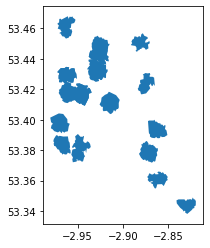

In [9]:
# Check it plots
travel_distances.plot()

In [10]:
# Export
with open('/notebooks/Isochrone.geojson', 'w') as f:
   dump(travel_distances, f)